# 0712: I think there are something wrong with the code of comb noise, but it's just the same as the matlab code.  use yita=0.6 as im/comb=0.2,yita=0.7 as all comb noise-----------0717-------------yita=im/comb, so it should be yita=0.6 as all comb noise,yita = 0.7 as im/comb=0.2-----------0717modified the comb_noise function,and try real value-------0720the comb noise is correct now, but the BER is still very low, simulate the BER performance-------------0905 yita=0.2 0.5 0.8 simulate-------

E:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


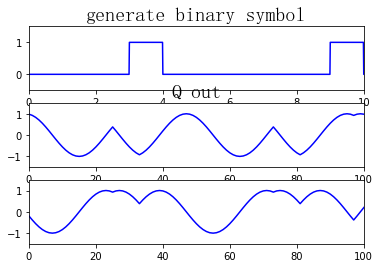

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:85: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


In [1]:
import matplotlib.pyplot as plt
import numpy as np 
from math import pi
from scipy import interpolate 
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal as signal
import math
from scipy.stats import levy_stable
import CommFunc as CF
from keras.utils import np_utils

#----------import my function-----------
import noise
import comb_noise as cmbn

# get the train and test data
# generate symbol

data_len=1000
sample_num=8
Rb=100
fc=20000
sampling_t=0.01
t=np.arange(0,data_len,sampling_t)
multi=int(fc/Rb)
def symbol_out(data_len):
  a = np.random.randint(0, 2, data_len)
  m = np.zeros(len(t), dtype=np.float32)
  for i in range(len(t)):
    m[i] = a[math.floor(t[i])]
  for i in range(len(a)):
    if a[i]>0:
      a[i]=a[i]
    else:
      a[i]=-1
  return a,m
data,data_p=symbol_out(data_len)
# 解决set_title中文乱码
 
zhfont1 = matplotlib.font_manager.FontProperties(fname = 'C:\Windows\Fonts\simsun.ttc')
#------plot figure----------
fig = plt.figure() 
ax1 = fig.add_subplot(3, 1, 1)
ax1.set_title('generate binary symbol', fontproperties = zhfont1, fontsize = 20)
 
plt.axis([0, 10, -0.5, 1.5])
 
plt.plot(t, data_p, 'b')

#---------- I and Q---------
def IQ_msk(data,data_len,sample_num,Rb):
    Tb=1/Rb
    #fs=Rb*sample_num
    # sampling
    data_sample=np.zeros(data_len*sample_num)
    count=0
    for i in range(data_len):
      data_sample[count:(i+1)*sample_num+1]=data[i]
      count=(i+1)*sample_num+1
    # phase
    phase=np.zeros(data_len*sample_num)
    phase[0]=data_sample[0]*pi/2/sample_num
    for i in range(1,data_len*sample_num):
      phase[i]=phase[i-1]+data_sample[i-1]*pi/2/sample_num
    I_out=np.cos(phase)
    Q_out=np.sin(phase)
    return I_out,Q_out
I_out,Q_out=IQ_msk(data,data_len,sample_num,Rb)
#-------plot figure--------------
ax2=fig.add_subplot(3,1,2)
ax2.set_title('I out', fontproperties = zhfont1, fontsize = 20)
plt.axis([0, 100, -1.5, 1.5])
plt.plot(I_out, 'b')
ax3=fig.add_subplot(3,1,3)
ax2.set_title('Q out', fontproperties = zhfont1, fontsize = 20)
plt.axis([0, 100, -1.5, 1.5])
plt.plot(Q_out, 'b')
plt.show()
#---modulate to defined frequency-----
def carriermod(fc,Rb,I_out,Q_out):
    pass
    multi = fc/Rb
    x_I=np.linspace(0,len(I_out)-1,len(I_out))
    x_Itemp=np.linspace(0,len(I_out)-1,(len(I_out)*multi))
    f_I = interpolate.interp1d(x_I,I_out,kind="slinear")
    I_temp=f_I(x_Itemp)
    x_Q=np.linspace(0,len(Q_out)-1,len(Q_out))
    x_Qtemp=np.linspace(0,len(Q_out)-1,(len(Q_out)*multi))
    f_Q = interpolate.interp1d(x_Q,Q_out,kind="slinear")
    Q_temp=f_Q(x_Qtemp)


    fs=fc*sample_num
    ts = np.arange(0, (len(I_temp)* 1) / fs, 1 / fs)
    signal_I=I_temp*np.cos(np.dot(2*pi*fc,ts))
    signal_Q=Q_temp*np.sin(np.dot(2*pi*fc,ts))

    signal_mod=signal_I-signal_Q
    return signal_mod
signal_mod=carriermod(fc,Rb,I_out,Q_out)

In [18]:
#--------------prepare the convolutional neural network-------------
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D,AveragePooling1D
from keras.layers.core import Dense, Lambda, GatedDense
from keras.utils import np_utils
print ('the library of the network has been prepared')
#-------------define the number of classes of the signal (means 0/1 )--------
num_classes = 2
#-----------construct the 1D CNN-----------------------
# 1D CNN neural network
#input_shape = 1600
model_m = Sequential()
model_m.add(Reshape((sample_num*5, 40), input_shape=(1600,)))
model_m.add(Conv1D(200, 4, activation='relu', input_shape=(sample_num,200)))
model_m.add(Conv1D(200, 4, activation='relu'))
#model_m.add(Reshape((200*34，))
model_m.add(GatedDense(128))
model_m.add(GatedDense(64))
model_m.add(GatedDense(32))
#model_m.add(Dense(128))
#model_m.add(Dense(64))
#model_m.add(AveragePooling1D(2))
#model_m.add(Conv1D(160, 5, activation='relu'))
#model_m.add(Conv1D(160, 4, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())


# In[66]:


#------------compile the CNN--------------
model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])
print('the model has been compiled')


the library of the network has been prepared
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 40, 40)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 37, 200)           32200     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 34, 200)           160200    
_________________________________________________________________
gated_dense_3 (GatedDense)   (None, 34, 128)           102912    
_________________________________________________________________
gated_dense_4 (GatedDense)   (None, 34, 64)            33024     
_________________________________________________________________
gated_dense_5 (GatedDense)   (None, 34, 32)            8320      
_________________________________________________________________
global_average_pooling1d_2 ( (N

# yita=0.2 train -2dB

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


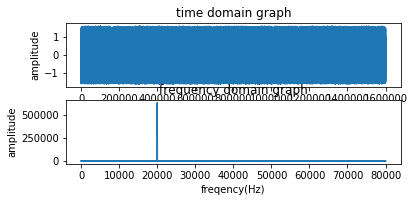

the noise has been prepared
the shape of impulsive noise (1600000,)
cmb [-0.66315575 -1.02659973 -1.5599467  ...  0.68977968  1.10006187
  0.96577586]
im_noise [ 0.03269013 -0.1042055  -0.050657   ...  0.13640831  0.14206981
 -0.05343001]
signals has been prepared
shape of X_train (1000, 1600) shape of y_train (1000, 2)
[[0. 1.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [1. 0.]]


In [55]:
from pylab import *
#------------prepare combine noise-------------------
yita = 0.2  #yita = imnoise/combine noise
EbN0 = -2 # -6 #-4 #0 #6   #15
fs = fc*sample_num
def combnoise2(ebn0,length,fc,fs):
	N = length
	snr = 10**((ebn0)/10)
	Ptotal = 1/snr
	#length = 1000
	#P_im = Ptotal*yita
	P_comb = Ptotal*(1-yita)
	ts = np.arange(1/fs, (N+1) / fs, 1 / fs)
	#comb_noise = (P_comb**0.5)*np.random.randn(length)*np.cos(np.dot(2*pi*fc,ts))
	cosn = np.cos(np.dot(2*pi*fc,ts))
	sinn = np.sin(np.dot(2*pi*fc,ts))
	cmb_noise =  (P_comb**0.5)*np.random.random(length)*np.cos(np.dot(2*pi*fc,ts))- (P_comb**0.5)*np.random.random(length)*np.sin(np.dot(2*pi*fc,ts))
	return cmb_noise

cmb_noise = combnoise2(EbN0,len(signal_mod),fc,fs)
fft = np.fft.fft(cmb_noise)  #调用fft变换算法计算频域波形
fftx = np.linspace(0,fs/2,len(signal_mod)/2)  #频域波形x轴坐标311
subplot(312)
plot(cmb_noise)
xlabel('time(s)')
ylabel('amplitude')
title('time domain graph')

subplot(313)
plot(fftx,abs(fft[0:800000]))
xlabel('freqency(Hz)')
ylabel('amplitude')
title('frequency domain graph')

show()
im_noise=cmbn.imnoise(EbN0,yita,signal_mod.shape,alpha=1.5)  #alpha=1.2
signal_mod0 = signal_mod+im_noise+cmb_noise
#X_train = signal_mod0.reshape(data_len,sample_num,200)
print('the noise has been prepared')
print('the shape of impulsive noise',im_noise.shape)
#------prpare the data-+---------------
X_train=np.zeros((data_len,1600))
X_test=np.zeros((data_len,1600))
X_train = signal_mod0.reshape(data_len,1600) 

data_0=(data+1)/2

#X_train_pre=signal_mod
y_train = np_utils.to_categorical(data_0, num_classes=2)
print('cmb',cmb_noise)
print('im_noise',im_noise)
y_test=y_train
#X_train = X_train_pre.reshape(data_len,sample_num*multi)
X_test=X_train

print ('signals has been prepared')
print('shape of X_train',X_train.shape,'shape of y_train',y_train.shape)
print(y_train)

Train on 800 samples, validate on 200 samples
Epoch 1/500
800/800 [==============================] - 0s 585us/step - loss: 0.0131 - acc: 1.0000 - val_loss: 0.0110 - val_acc: 1.0000
Epoch 2/500
800/800 [==============================] - 0s 598us/step - loss: 0.0130 - acc: 1.0000 - val_loss: 0.0102 - val_acc: 1.0000
Epoch 3/500
800/800 [==============================] - 0s 591us/step - loss: 0.0123 - acc: 1.0000 - val_loss: 0.0096 - val_acc: 1.0000
Epoch 4/500
800/800 [==============================] - 0s 594us/step - loss: 0.0128 - acc: 1.0000 - val_loss: 0.0089 - val_acc: 1.0000
Epoch 5/500
800/800 [==============================] - 0s 588us/step - loss: 0.0130 - acc: 1.0000 - val_loss: 0.0083 - val_acc: 1.0000
Epoch 6/500
800/800 [==============================] - 0s 621us/step - loss: 0.0120 - acc: 1.0000 - val_loss: 0.0079 - val_acc: 1.0000
Epoch 7/500
800/800 [==============================] - 0s 607us/step - loss: 0.0120 - acc: 1.0000 - val_loss: 0.0076 - val_acc: 1.0000
Epoch 8/5

Epoch 61/500
800/800 [==============================] - 0s 586us/step - loss: 0.0097 - acc: 1.0000 - val_loss: 0.0062 - val_acc: 1.0000
Epoch 62/500
800/800 [==============================] - 0s 603us/step - loss: 0.0099 - acc: 1.0000 - val_loss: 0.0061 - val_acc: 1.0000
Epoch 63/500
800/800 [==============================] - 0s 581us/step - loss: 0.0098 - acc: 1.0000 - val_loss: 0.0061 - val_acc: 1.0000
Epoch 64/500
800/800 [==============================] - 0s 606us/step - loss: 0.0097 - acc: 1.0000 - val_loss: 0.0061 - val_acc: 1.0000
Epoch 65/500
800/800 [==============================] - 0s 586us/step - loss: 0.0096 - acc: 1.0000 - val_loss: 0.0061 - val_acc: 1.0000
Epoch 66/500
800/800 [==============================] - 0s 582us/step - loss: 0.0097 - acc: 1.0000 - val_loss: 0.0061 - val_acc: 1.0000
Epoch 67/500
800/800 [==============================] - 0s 584us/step - loss: 0.0099 - acc: 1.0000 - val_loss: 0.0061 - val_acc: 1.0000
Epoch 68/500
800/800 [==========================

800/800 [==============================] - 0s 588us/step - loss: 0.0087 - acc: 1.0000 - val_loss: 0.0057 - val_acc: 1.0000
Epoch 122/500
800/800 [==============================] - 0s 603us/step - loss: 0.0086 - acc: 1.0000 - val_loss: 0.0057 - val_acc: 1.0000
Epoch 123/500
800/800 [==============================] - 0s 566us/step - loss: 0.0086 - acc: 1.0000 - val_loss: 0.0057 - val_acc: 1.0000
Epoch 124/500
800/800 [==============================] - 0s 586us/step - loss: 0.0087 - acc: 1.0000 - val_loss: 0.0057 - val_acc: 1.0000
Epoch 125/500
800/800 [==============================] - 0s 599us/step - loss: 0.0086 - acc: 1.0000 - val_loss: 0.0056 - val_acc: 1.0000
Epoch 126/500
800/800 [==============================] - 0s 598us/step - loss: 0.0086 - acc: 1.0000 - val_loss: 0.0056 - val_acc: 1.0000
Epoch 127/500
800/800 [==============================] - 0s 593us/step - loss: 0.0086 - acc: 1.0000 - val_loss: 0.0056 - val_acc: 1.0000
Epoch 128/500
800/800 [==============================] 

Epoch 181/500
800/800 [==============================] - 0s 606us/step - loss: 0.0081 - acc: 1.0000 - val_loss: 0.0054 - val_acc: 1.0000
Epoch 182/500
800/800 [==============================] - 0s 610us/step - loss: 0.0079 - acc: 1.0000 - val_loss: 0.0053 - val_acc: 1.0000
Epoch 183/500
800/800 [==============================] - 0s 577us/step - loss: 0.0078 - acc: 1.0000 - val_loss: 0.0053 - val_acc: 1.0000
Epoch 184/500
800/800 [==============================] - 0s 599us/step - loss: 0.0081 - acc: 1.0000 - val_loss: 0.0053 - val_acc: 1.0000
Epoch 185/500
800/800 [==============================] - 0s 608us/step - loss: 0.0078 - acc: 1.0000 - val_loss: 0.0053 - val_acc: 1.0000
Epoch 186/500
800/800 [==============================] - 0s 565us/step - loss: 0.0077 - acc: 1.0000 - val_loss: 0.0053 - val_acc: 1.0000
Epoch 187/500
800/800 [==============================] - 0s 605us/step - loss: 0.0077 - acc: 1.0000 - val_loss: 0.0053 - val_acc: 1.0000
Epoch 188/500
800/800 [==================

Epoch 241/500
800/800 [==============================] - 0s 620us/step - loss: 0.0072 - acc: 1.0000 - val_loss: 0.0049 - val_acc: 1.0000
Epoch 242/500
800/800 [==============================] - 0s 611us/step - loss: 0.0072 - acc: 1.0000 - val_loss: 0.0049 - val_acc: 1.0000
Epoch 243/500
800/800 [==============================] - 1s 638us/step - loss: 0.0070 - acc: 1.0000 - val_loss: 0.0049 - val_acc: 1.0000
Epoch 244/500
800/800 [==============================] - 0s 600us/step - loss: 0.0070 - acc: 1.0000 - val_loss: 0.0049 - val_acc: 1.0000
Epoch 245/500
800/800 [==============================] - 0s 575us/step - loss: 0.0070 - acc: 1.0000 - val_loss: 0.0049 - val_acc: 1.0000
Epoch 246/500
800/800 [==============================] - 0s 605us/step - loss: 0.0072 - acc: 1.0000 - val_loss: 0.0049 - val_acc: 1.0000
Epoch 247/500
800/800 [==============================] - 0s 581us/step - loss: 0.0071 - acc: 1.0000 - val_loss: 0.0049 - val_acc: 1.0000
Epoch 248/500
800/800 [==================

Epoch 301/500
800/800 [==============================] - 0s 590us/step - loss: 0.0065 - acc: 1.0000 - val_loss: 0.0046 - val_acc: 1.0000
Epoch 302/500
800/800 [==============================] - 0s 602us/step - loss: 0.0066 - acc: 1.0000 - val_loss: 0.0045 - val_acc: 1.0000
Epoch 303/500
800/800 [==============================] - 0s 600us/step - loss: 0.0065 - acc: 1.0000 - val_loss: 0.0045 - val_acc: 1.0000
Epoch 304/500
800/800 [==============================] - 1s 626us/step - loss: 0.0066 - acc: 1.0000 - val_loss: 0.0046 - val_acc: 1.0000
Epoch 305/500
800/800 [==============================] - 0s 608us/step - loss: 0.0065 - acc: 1.0000 - val_loss: 0.0046 - val_acc: 1.0000
Epoch 306/500
800/800 [==============================] - 0s 622us/step - loss: 0.0065 - acc: 1.0000 - val_loss: 0.0045 - val_acc: 1.0000
Epoch 307/500
800/800 [==============================] - 0s 575us/step - loss: 0.0065 - acc: 1.0000 - val_loss: 0.0045 - val_acc: 1.0000
Epoch 308/500
800/800 [==================

Epoch 361/500
800/800 [==============================] - 0s 601us/step - loss: 0.0059 - acc: 1.0000 - val_loss: 0.0042 - val_acc: 1.0000
Epoch 362/500
800/800 [==============================] - 1s 643us/step - loss: 0.0060 - acc: 1.0000 - val_loss: 0.0042 - val_acc: 1.0000
Epoch 363/500
800/800 [==============================] - 0s 586us/step - loss: 0.0059 - acc: 1.0000 - val_loss: 0.0042 - val_acc: 1.0000
Epoch 364/500
800/800 [==============================] - 0s 583us/step - loss: 0.0059 - acc: 1.0000 - val_loss: 0.0043 - val_acc: 1.0000
Epoch 365/500
800/800 [==============================] - 0s 584us/step - loss: 0.0060 - acc: 1.0000 - val_loss: 0.0043 - val_acc: 1.0000
Epoch 366/500
800/800 [==============================] - 0s 603us/step - loss: 0.0063 - acc: 1.0000 - val_loss: 0.0044 - val_acc: 1.0000
Epoch 367/500
800/800 [==============================] - 0s 608us/step - loss: 0.0061 - acc: 1.0000 - val_loss: 0.0044 - val_acc: 1.0000
Epoch 368/500
800/800 [==================

Epoch 421/500
800/800 [==============================] - 0s 623us/step - loss: 0.0054 - acc: 1.0000 - val_loss: 0.0040 - val_acc: 1.0000
Epoch 422/500
800/800 [==============================] - 0s 587us/step - loss: 0.0056 - acc: 1.0000 - val_loss: 0.0040 - val_acc: 1.0000
Epoch 423/500
800/800 [==============================] - 0s 583us/step - loss: 0.0055 - acc: 1.0000 - val_loss: 0.0040 - val_acc: 1.0000
Epoch 424/500
800/800 [==============================] - 1s 644us/step - loss: 0.0054 - acc: 1.0000 - val_loss: 0.0040 - val_acc: 1.0000
Epoch 425/500
800/800 [==============================] - 0s 585us/step - loss: 0.0053 - acc: 1.0000 - val_loss: 0.0040 - val_acc: 1.0000
Epoch 426/500
800/800 [==============================] - 0s 601us/step - loss: 0.0055 - acc: 1.0000 - val_loss: 0.0040 - val_acc: 1.0000
Epoch 427/500
800/800 [==============================] - 0s 589us/step - loss: 0.0057 - acc: 1.0000 - val_loss: 0.0041 - val_acc: 1.0000
Epoch 428/500
800/800 [==================

Epoch 481/500
800/800 [==============================] - 0s 586us/step - loss: 0.0052 - acc: 1.0000 - val_loss: 0.0038 - val_acc: 1.0000
Epoch 482/500
800/800 [==============================] - 0s 600us/step - loss: 0.0051 - acc: 1.0000 - val_loss: 0.0038 - val_acc: 1.0000
Epoch 483/500
800/800 [==============================] - 0s 611us/step - loss: 0.0051 - acc: 1.0000 - val_loss: 0.0038 - val_acc: 1.0000
Epoch 484/500
800/800 [==============================] - 0s 581us/step - loss: 0.0050 - acc: 1.0000 - val_loss: 0.0037 - val_acc: 1.0000
Epoch 485/500
800/800 [==============================] - 0s 614us/step - loss: 0.0050 - acc: 1.0000 - val_loss: 0.0037 - val_acc: 1.0000
Epoch 486/500
800/800 [==============================] - 0s 591us/step - loss: 0.0050 - acc: 1.0000 - val_loss: 0.0037 - val_acc: 1.0000
Epoch 487/500
800/800 [==============================] - 0s 617us/step - loss: 0.0050 - acc: 1.0000 - val_loss: 0.0037 - val_acc: 1.0000
Epoch 488/500
800/800 [==================

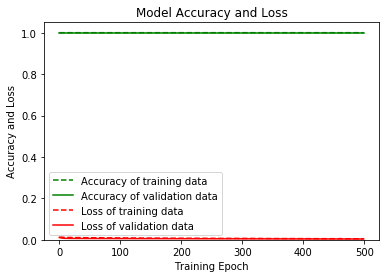

In [56]:
#-------------load the model-------------
from keras.models import load_model 
#model_m = load_model ('GCNN_tr-2dBv7_alpha15.h5')
##-----------the training parameters---------------
# Hyper-parameters
BATCH_SIZE = 500
EPOCHS = 500
#for i in range(2):
#    X_train[0:data_len,0:sample_num,i]= X_train[0:data_len,0:sample_num,i] +im_noise[0,0:data_len,0:sample_num]
    #X_test[0:data_len,0:sample_num,i]= X_test[0:data_len,0:sample_num,i] +im_noise[7,0:data_len,0:sample_num]
#X_test=X_test+im_noise
# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                    #  callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)
                     

# %%
#score = model_m.evaluate(X_test, y_test, verbose=1)
#print("\nAccuracy on test data: %0.2f" % score[1])
#print("\nLoss on test data: %0.2f" % score[0])
print("\n--- Learning curve of model training ---\n")
# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['acc'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_acc'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
#np.savetxt('loss_MSK_GCNN_tr-2dB_alpha12.txt',history.history['loss'],fmt='%0.8f')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()
model_m.save('GCNN_tr2dB_comb0.h5')

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:85: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


data_0 [0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0.
 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1.
 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1.
 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1.
 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0.
 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1.
 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1.
 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0.
 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1.
 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0.
 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1.
 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1

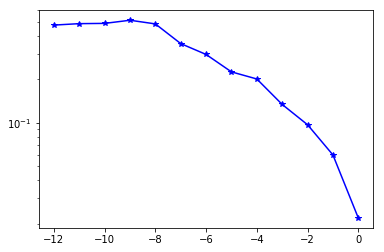

save txt have done


In [57]:
#------test data generating---------------
data,data_p=symbol_out(data_len)
I_out,Q_out=IQ_msk(data,data_len,sample_num,Rb)
signal_mod=carriermod(fc,Rb,I_out,Q_out)
#--generate noise--------------


#X_train = signal_mod0.reshape(data_len,sample_num,200)

#signal_mod0 = signal_mod + im_noise

data_0=(data+1)/2
print('data_0',data_0)
Y_test = np_utils.to_categorical(data_0, num_classes=2)
print('Y_test',Y_test)
#*************alpha=1.5*******************************************
model2 = model_m
#-----test and plot----------
#---plot ber curve-------------
yita=0.2
EbN0 =[-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0] # ##[-5,-4,-3,-2,-1,0,1,2,3] #[-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2] # #[-8,-7,-6,-5,-4,-3,-2,-1,0]  #[1,2,3,4,5] # 
BER = [0]*len(EbN0)
loop_num = [1]*len(EbN0)    #[1,1,10,10,10,10,100,100,1000]
for i in range(len(EbN0)):
  #EbN0[i] = GSNR[i]/2
  cmb_noise = combnoise2(EbN0[i],len(signal_mod),fc,fs)
  #print(cmb_noise)


  im_noise=cmbn.imnoise(EbN0[i],yita,signal_mod.shape,alpha=1.5)
  signal_mod0 = signal_mod+im_noise+cmb_noise
  X_test = signal_mod0.reshape(data_len,1600) 
  BER_loop = [0]*loop_num[i]
  wrong = [0]*loop_num[i]
  wrong_sum = 0
  for loop in range(loop_num[i]):
    
    loss,accuracy = model2.evaluate(X_test, Y_test)
    BER_loop[loop] = 1- accuracy
    wrong[loop] = BER_loop[loop]*data_len
  wrong_sum = sum(wrong)
  BER[i] = wrong_sum/(data_len*loop_num[i])
  print('BER',BER[i])
plt.semilogy(EbN0,BER,'b*-')
plt.savefig('BER_MSK_GCNN_tr2dBv8_te_5_2dB_alpha12.jpg')
plt.show()
np.savetxt('BER_MSK_GCNN_tr-2dBv20_te_12_0_comb.txt',BER,fmt='%0.8f')
print('save txt have done')

In [58]:
np.savetxt('BER_MSK_GCNN0905_tr-2dB_te_12_0_comb02.txt',BER,fmt='%0.8f')
print('save txt have done')

save txt have done


# yita=0.5 train-2dB

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


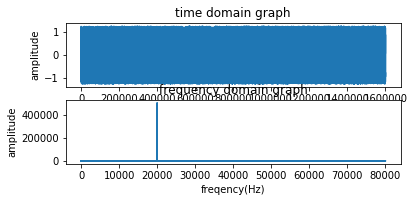

the noise has been prepared
the shape of impulsive noise (1600000,)
cmb [-0.07219863 -0.49425942 -0.87533414 ...  0.88273843  0.80325932
  0.09540162]
im_noise [-0.05930974 -0.04481251 -0.17366813 ... -0.10543917  0.18630743
  0.27245781]
signals has been prepared
shape of X_train (1000, 1600) shape of y_train (1000, 2)
[[0. 1.]
 [1. 0.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Train on 800 samples, validate on 200 samples
Epoch 1/200
800/800 [==============================] - 0s 579us/step - loss: 0.1571 - acc: 0.9300 - val_loss: 0.2372 - val_acc: 0.9000
Epoch 2/200
800/800 [==============================] - 0s 608us/step - loss: 0.1732 - acc: 0.9388 - val_loss: 0.2362 - val_acc: 0.9350
Epoch 3/200
800/800 [==============================] - 1s 636us/step - loss: 0.3056 - acc: 0.8813 - val_loss: 0.1076 - val_acc: 0.9700
Epoch 4/200
800/800 [==============================] - 1s 647us/step - loss: 0.1699 - acc: 0.9350 - val_loss: 0.0889 - val_acc: 0.9850
Epoch 5/200
800/800 [===========

800/800 [==============================] - 1s 678us/step - loss: 0.0194 - acc: 0.9988 - val_loss: 0.0219 - val_acc: 1.0000
Epoch 59/200
800/800 [==============================] - 1s 684us/step - loss: 0.0198 - acc: 0.9988 - val_loss: 0.0219 - val_acc: 1.0000
Epoch 60/200
800/800 [==============================] - 0s 605us/step - loss: 0.0183 - acc: 1.0000 - val_loss: 0.0219 - val_acc: 1.0000
Epoch 61/200
800/800 [==============================] - 0s 608us/step - loss: 0.0190 - acc: 1.0000 - val_loss: 0.0218 - val_acc: 1.0000
Epoch 62/200
800/800 [==============================] - 1s 638us/step - loss: 0.0188 - acc: 1.0000 - val_loss: 0.0216 - val_acc: 1.0000
Epoch 63/200
800/800 [==============================] - 1s 652us/step - loss: 0.0175 - acc: 1.0000 - val_loss: 0.0215 - val_acc: 1.0000
Epoch 64/200
800/800 [==============================] - 1s 635us/step - loss: 0.0192 - acc: 1.0000 - val_loss: 0.0214 - val_acc: 1.0000
Epoch 65/200
800/800 [==============================] - 0s 60

800/800 [==============================] - 1s 646us/step - loss: 0.0150 - acc: 1.0000 - val_loss: 0.0191 - val_acc: 1.0000
Epoch 119/200
800/800 [==============================] - 0s 602us/step - loss: 0.0160 - acc: 1.0000 - val_loss: 0.0191 - val_acc: 1.0000
Epoch 120/200
800/800 [==============================] - 0s 585us/step - loss: 0.0152 - acc: 1.0000 - val_loss: 0.0191 - val_acc: 1.0000
Epoch 121/200
800/800 [==============================] - 0s 602us/step - loss: 0.0155 - acc: 1.0000 - val_loss: 0.0191 - val_acc: 1.0000
Epoch 122/200
800/800 [==============================] - 0s 605us/step - loss: 0.0149 - acc: 1.0000 - val_loss: 0.0191 - val_acc: 1.0000
Epoch 123/200
800/800 [==============================] - 0s 603us/step - loss: 0.0139 - acc: 1.0000 - val_loss: 0.0191 - val_acc: 1.0000
Epoch 124/200
800/800 [==============================] - 1s 626us/step - loss: 0.0151 - acc: 1.0000 - val_loss: 0.0190 - val_acc: 1.0000
Epoch 125/200
800/800 [==============================] 

Epoch 178/200
800/800 [==============================] - 0s 622us/step - loss: 0.0127 - acc: 1.0000 - val_loss: 0.0181 - val_acc: 1.0000
Epoch 179/200
800/800 [==============================] - 0s 605us/step - loss: 0.0130 - acc: 1.0000 - val_loss: 0.0181 - val_acc: 1.0000
Epoch 180/200
800/800 [==============================] - 0s 583us/step - loss: 0.0126 - acc: 1.0000 - val_loss: 0.0181 - val_acc: 1.0000
Epoch 181/200
800/800 [==============================] - 0s 584us/step - loss: 0.0130 - acc: 1.0000 - val_loss: 0.0181 - val_acc: 1.0000
Epoch 182/200
800/800 [==============================] - 0s 623us/step - loss: 0.0131 - acc: 1.0000 - val_loss: 0.0180 - val_acc: 1.0000
Epoch 183/200
800/800 [==============================] - 0s 585us/step - loss: 0.0125 - acc: 1.0000 - val_loss: 0.0180 - val_acc: 1.0000
Epoch 184/200
800/800 [==============================] - 0s 624us/step - loss: 0.0125 - acc: 1.0000 - val_loss: 0.0180 - val_acc: 1.0000
Epoch 185/200
800/800 [==================

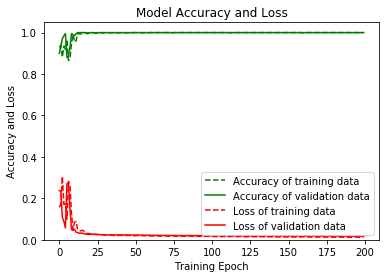

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:85: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


data_0 [1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1.
 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1.
 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0.
 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1.
 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1.
 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0.
 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0.
 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1.
 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1.
 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1

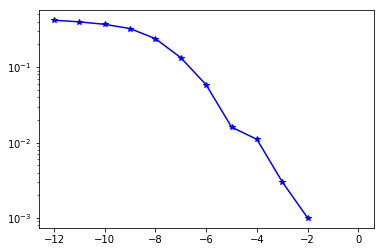

save txt have done


In [41]:
from pylab import *
#------------prepare combine noise-------------------
yita = 0.5  #yita = imnoise/combine noise
EbN0 = -2 # -6 #-4 #0 #6   #15
fs = fc*sample_num
def combnoise2(ebn0,length,fc,fs):
	N = length
	snr = 10**((ebn0)/10)
	Ptotal = 1/snr
	#length = 1000
	#P_im = Ptotal*yita
	P_comb = Ptotal*(1-yita)
	ts = np.arange(1/fs, (N+1) / fs, 1 / fs)
	#comb_noise = (P_comb**0.5)*np.random.randn(length)*np.cos(np.dot(2*pi*fc,ts))
	cosn = np.cos(np.dot(2*pi*fc,ts))
	sinn = np.sin(np.dot(2*pi*fc,ts))
	cmb_noise =  (P_comb**0.5)*np.random.random(length)*np.cos(np.dot(2*pi*fc,ts))- (P_comb**0.5)*np.random.random(length)*np.sin(np.dot(2*pi*fc,ts))
	return cmb_noise

cmb_noise = combnoise2(EbN0,len(signal_mod),fc,fs)
fft = np.fft.fft(cmb_noise)  #调用fft变换算法计算频域波形
fftx = np.linspace(0,fs/2,len(signal_mod)/2)  #频域波形x轴坐标311
subplot(312)
plot(cmb_noise)
xlabel('time(s)')
ylabel('amplitude')
title('time domain graph')

subplot(313)
plot(fftx,abs(fft[0:800000]))
xlabel('freqency(Hz)')
ylabel('amplitude')
title('frequency domain graph')

show()
im_noise=cmbn.imnoise(EbN0,yita,signal_mod.shape,alpha=1.5)  #alpha=1.2
signal_mod0 = signal_mod+im_noise+cmb_noise
#X_train = signal_mod0.reshape(data_len,sample_num,200)
print('the noise has been prepared')
print('the shape of impulsive noise',im_noise.shape)
#------prpare the data-+---------------
X_train=np.zeros((data_len,1600))
X_test=np.zeros((data_len,1600))
X_train = signal_mod0.reshape(data_len,1600) 

data_0=(data+1)/2

#X_train_pre=signal_mod
y_train = np_utils.to_categorical(data_0, num_classes=2)
print('cmb',cmb_noise)
print('im_noise',im_noise)
y_test=y_train
#X_train = X_train_pre.reshape(data_len,sample_num*multi)
X_test=X_train

print ('signals has been prepared')
print('shape of X_train',X_train.shape,'shape of y_train',y_train.shape)
print(y_train)

#*******************------------TRAIN-----------*******************
#-------------load the model-------------
from keras.models import load_model 
#model_m = load_model ('GCNN_tr-2dBv7_alpha15.h5')
##-----------the training parameters---------------
# Hyper-parameters
BATCH_SIZE = 500
EPOCHS = 200
#for i in range(2):
#    X_train[0:data_len,0:sample_num,i]= X_train[0:data_len,0:sample_num,i] +im_noise[0,0:data_len,0:sample_num]
    #X_test[0:data_len,0:sample_num,i]= X_test[0:data_len,0:sample_num,i] +im_noise[7,0:data_len,0:sample_num]
#X_test=X_test+im_noise
# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                    #  callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)
                     

# %%
#score = model_m.evaluate(X_test, y_test, verbose=1)
#print("\nAccuracy on test data: %0.2f" % score[1])
#print("\nLoss on test data: %0.2f" % score[0])
print("\n--- Learning curve of model training ---\n")
# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['acc'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_acc'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
#np.savetxt('loss_MSK_GCNN_tr-2dB_alpha12.txt',history.history['loss'],fmt='%0.8f')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()
model_m.save('GCNN_tr-2dB_comb05.h5')

#**********************------TEST-----------************************
#------test data generating---------------
data,data_p=symbol_out(data_len)
I_out,Q_out=IQ_msk(data,data_len,sample_num,Rb)
signal_mod=carriermod(fc,Rb,I_out,Q_out)
#--generate noise--------------


#X_train = signal_mod0.reshape(data_len,sample_num,200)

#signal_mod0 = signal_mod + im_noise

data_0=(data+1)/2
print('data_0',data_0)
Y_test = np_utils.to_categorical(data_0, num_classes=2)
print('Y_test',Y_test)
#*************alpha=1.5*******************************************
model2 = model_m
#-----test and plot----------
#---plot ber curve-------------
yita=0.5
EbN0 =[-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0] # ##[-5,-4,-3,-2,-1,0,1,2,3] #[-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2] # #[-8,-7,-6,-5,-4,-3,-2,-1,0]  #[1,2,3,4,5] # 
BER = [0]*len(EbN0)
loop_num = [1]*len(EbN0)    #[1,1,10,10,10,10,100,100,1000]
for i in range(len(EbN0)):
  #EbN0[i] = GSNR[i]/2
  cmb_noise = combnoise2(EbN0[i],len(signal_mod),fc,fs)
  #print(cmb_noise)


  im_noise=cmbn.imnoise(EbN0[i],yita,signal_mod.shape,alpha=1.5)
  signal_mod0 = signal_mod+im_noise+cmb_noise
  X_test = signal_mod0.reshape(data_len,1600) 
  BER_loop = [0]*loop_num[i]
  wrong = [0]*loop_num[i]
  wrong_sum = 0
  for loop in range(loop_num[i]):
    
    loss,accuracy = model2.evaluate(X_test, Y_test)
    BER_loop[loop] = 1- accuracy
    wrong[loop] = BER_loop[loop]*data_len
  wrong_sum = sum(wrong)
  BER[i] = wrong_sum/(data_len*loop_num[i])
  print('BER',BER[i])
plt.semilogy(EbN0,BER,'b*-')
plt.savefig('BER_MSK_GCNN_tr2dBv8_te_5_2dB_alpha12.jpg')
plt.show()
np.savetxt('BER_MSK_GCNN0905_tr-2dB_te_12_0_comb05.txt',BER,fmt='%0.8f')
print('save txt have done')
     

# yita = 0.8 train-2dB

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


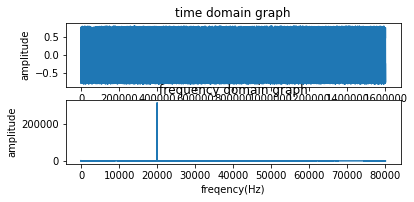

the noise has been prepared
the shape of impulsive noise (1600000,)
cmb [ 0.14866274 -0.29718995 -0.24648078 ...  0.53556582  0.34942965
  0.48022643]
im_noise [ 0.22560085  0.53254532  0.44569318 ... -0.36177857  1.78575284
 -1.08512969]
signals has been prepared
shape of X_train (1000, 1600) shape of y_train (1000, 2)
[[0. 1.]
 [0. 1.]
 [1. 0.]
 ...
 [0. 1.]
 [1. 0.]
 [0. 1.]]
Train on 800 samples, validate on 200 samples
Epoch 1/200
800/800 [==============================] - 0s 579us/step - loss: 0.0573 - acc: 0.9850 - val_loss: 0.0700 - val_acc: 0.9800
Epoch 2/200
800/800 [==============================] - 0s 613us/step - loss: 0.0470 - acc: 0.9912 - val_loss: 0.0660 - val_acc: 0.9800
Epoch 3/200
800/800 [==============================] - 0s 620us/step - loss: 0.0455 - acc: 0.9938 - val_loss: 0.0595 - val_acc: 0.9850
Epoch 4/200
800/800 [==============================] - 0s 624us/step - loss: 0.0384 - acc: 0.9950 - val_loss: 0.0531 - val_acc: 0.9850
Epoch 5/200
800/800 [===========

800/800 [==============================] - 0s 624us/step - loss: 0.0192 - acc: 0.9975 - val_loss: 0.0343 - val_acc: 0.9950
Epoch 59/200
800/800 [==============================] - 0s 624us/step - loss: 0.0181 - acc: 0.9988 - val_loss: 0.0341 - val_acc: 0.9950
Epoch 60/200
800/800 [==============================] - 0s 606us/step - loss: 0.0187 - acc: 0.9988 - val_loss: 0.0337 - val_acc: 0.9950
Epoch 61/200
800/800 [==============================] - 0s 600us/step - loss: 0.0190 - acc: 0.9988 - val_loss: 0.0334 - val_acc: 0.9950
Epoch 62/200
800/800 [==============================] - 1s 626us/step - loss: 0.0181 - acc: 1.0000 - val_loss: 0.0331 - val_acc: 0.9950
Epoch 63/200
800/800 [==============================] - 1s 627us/step - loss: 0.0178 - acc: 0.9988 - val_loss: 0.0330 - val_acc: 0.9950
Epoch 64/200
800/800 [==============================] - 1s 626us/step - loss: 0.0189 - acc: 0.9988 - val_loss: 0.0329 - val_acc: 0.9950
Epoch 65/200
800/800 [==============================] - 1s 66

800/800 [==============================] - 0s 610us/step - loss: 0.0141 - acc: 0.9988 - val_loss: 0.0320 - val_acc: 0.9950
Epoch 119/200
800/800 [==============================] - 0s 621us/step - loss: 0.0140 - acc: 1.0000 - val_loss: 0.0320 - val_acc: 0.9950
Epoch 120/200
800/800 [==============================] - 0s 623us/step - loss: 0.0155 - acc: 0.9988 - val_loss: 0.0321 - val_acc: 0.9950
Epoch 121/200
800/800 [==============================] - 0s 603us/step - loss: 0.0146 - acc: 1.0000 - val_loss: 0.0321 - val_acc: 0.9950
Epoch 122/200
800/800 [==============================] - 0s 606us/step - loss: 0.0150 - acc: 1.0000 - val_loss: 0.0321 - val_acc: 0.9950
Epoch 123/200
800/800 [==============================] - 0s 605us/step - loss: 0.0143 - acc: 1.0000 - val_loss: 0.0320 - val_acc: 0.9950
Epoch 124/200
800/800 [==============================] - 1s 641us/step - loss: 0.0139 - acc: 1.0000 - val_loss: 0.0320 - val_acc: 0.9950
Epoch 125/200
800/800 [==============================] 

Epoch 178/200
800/800 [==============================] - 1s 636us/step - loss: 0.0133 - acc: 1.0000 - val_loss: 0.0309 - val_acc: 0.9950
Epoch 179/200
800/800 [==============================] - 0s 623us/step - loss: 0.0125 - acc: 1.0000 - val_loss: 0.0309 - val_acc: 0.9950
Epoch 180/200
800/800 [==============================] - 0s 622us/step - loss: 0.0133 - acc: 0.9988 - val_loss: 0.0309 - val_acc: 0.9950
Epoch 181/200
800/800 [==============================] - 0s 617us/step - loss: 0.0131 - acc: 0.9988 - val_loss: 0.0309 - val_acc: 0.9950
Epoch 182/200
800/800 [==============================] - 0s 612us/step - loss: 0.0127 - acc: 0.9988 - val_loss: 0.0309 - val_acc: 0.9950
Epoch 183/200
800/800 [==============================] - 0s 623us/step - loss: 0.0118 - acc: 0.9988 - val_loss: 0.0308 - val_acc: 0.9950
Epoch 184/200
800/800 [==============================] - 0s 607us/step - loss: 0.0127 - acc: 1.0000 - val_loss: 0.0307 - val_acc: 0.9950
Epoch 185/200
800/800 [==================

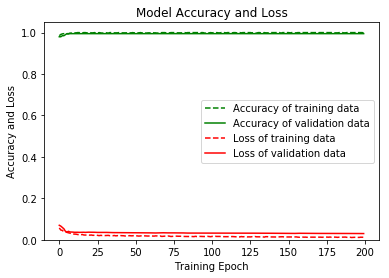

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:85: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


data_0 [1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0.
 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0.
 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0.
 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0.
 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1.
 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1.
 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1.
 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1.
 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0.
 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0.
 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1

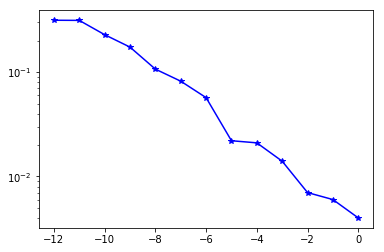

save txt have done


In [42]:
from pylab import *
#------------prepare combine noise-------------------
yita = 0.8  #yita = imnoise/combine noise
EbN0 = -2 # -6 #-4 #0 #6   #15
fs = fc*sample_num
def combnoise2(ebn0,length,fc,fs):
	N = length
	snr = 10**((ebn0)/10)
	Ptotal = 1/snr
	#length = 1000
	#P_im = Ptotal*yita
	P_comb = Ptotal*(1-yita)
	ts = np.arange(1/fs, (N+1) / fs, 1 / fs)
	#comb_noise = (P_comb**0.5)*np.random.randn(length)*np.cos(np.dot(2*pi*fc,ts))
	cosn = np.cos(np.dot(2*pi*fc,ts))
	sinn = np.sin(np.dot(2*pi*fc,ts))
	cmb_noise =  (P_comb**0.5)*np.random.random(length)*np.cos(np.dot(2*pi*fc,ts))- (P_comb**0.5)*np.random.random(length)*np.sin(np.dot(2*pi*fc,ts))
	return cmb_noise

cmb_noise = combnoise2(EbN0,len(signal_mod),fc,fs)
fft = np.fft.fft(cmb_noise)  #调用fft变换算法计算频域波形
fftx = np.linspace(0,fs/2,len(signal_mod)/2)  #频域波形x轴坐标311
subplot(312)
plot(cmb_noise)
xlabel('time(s)')
ylabel('amplitude')
title('time domain graph')

subplot(313)
plot(fftx,abs(fft[0:800000]))
xlabel('freqency(Hz)')
ylabel('amplitude')
title('frequency domain graph')

show()
im_noise=cmbn.imnoise(EbN0,yita,signal_mod.shape,alpha=1.5)  #alpha=1.2
signal_mod0 = signal_mod+im_noise+cmb_noise
#X_train = signal_mod0.reshape(data_len,sample_num,200)
print('the noise has been prepared')
print('the shape of impulsive noise',im_noise.shape)
#------prpare the data-+---------------
X_train=np.zeros((data_len,1600))
X_test=np.zeros((data_len,1600))
X_train = signal_mod0.reshape(data_len,1600) 

data_0=(data+1)/2

#X_train_pre=signal_mod
y_train = np_utils.to_categorical(data_0, num_classes=2)
print('cmb',cmb_noise)
print('im_noise',im_noise)
y_test=y_train
#X_train = X_train_pre.reshape(data_len,sample_num*multi)
X_test=X_train

print ('signals has been prepared')
print('shape of X_train',X_train.shape,'shape of y_train',y_train.shape)
print(y_train)

#*******************------------TRAIN-----------*******************
#-------------load the model-------------
from keras.models import load_model 
#model_m = load_model ('GCNN_tr-2dBv7_alpha15.h5')
##-----------the training parameters---------------
# Hyper-parameters
BATCH_SIZE = 500
EPOCHS = 200
#for i in range(2):
#    X_train[0:data_len,0:sample_num,i]= X_train[0:data_len,0:sample_num,i] +im_noise[0,0:data_len,0:sample_num]
    #X_test[0:data_len,0:sample_num,i]= X_test[0:data_len,0:sample_num,i] +im_noise[7,0:data_len,0:sample_num]
#X_test=X_test+im_noise
# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                    #  callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)
                     

# %%
#score = model_m.evaluate(X_test, y_test, verbose=1)
#print("\nAccuracy on test data: %0.2f" % score[1])
#print("\nLoss on test data: %0.2f" % score[0])
print("\n--- Learning curve of model training ---\n")
# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['acc'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_acc'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
#np.savetxt('loss_MSK_GCNN_tr-2dB_alpha12.txt',history.history['loss'],fmt='%0.8f')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()
model_m.save('GCNN_tr-2dB_comb08.h5')

#**********************------TEST-----------************************
#------test data generating---------------
data,data_p=symbol_out(data_len)
I_out,Q_out=IQ_msk(data,data_len,sample_num,Rb)
signal_mod=carriermod(fc,Rb,I_out,Q_out)
#--generate noise--------------


#X_train = signal_mod0.reshape(data_len,sample_num,200)

#signal_mod0 = signal_mod + im_noise

data_0=(data+1)/2
print('data_0',data_0)
Y_test = np_utils.to_categorical(data_0, num_classes=2)
print('Y_test',Y_test)
#*************alpha=1.5*******************************************
model2 = model_m
#-----test and plot----------
#---plot ber curve-------------
yita=0.8
EbN0 =[-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0] # ##[-5,-4,-3,-2,-1,0,1,2,3] #[-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2] # #[-8,-7,-6,-5,-4,-3,-2,-1,0]  #[1,2,3,4,5] # 
BER = [0]*len(EbN0)
loop_num = [1]*len(EbN0)    #[1,1,10,10,10,10,100,100,1000]
for i in range(len(EbN0)):
  #EbN0[i] = GSNR[i]/2
  cmb_noise = combnoise2(EbN0[i],len(signal_mod),fc,fs)
  #print(cmb_noise)


  im_noise=cmbn.imnoise(EbN0[i],yita,signal_mod.shape,alpha=1.5)
  signal_mod0 = signal_mod+im_noise+cmb_noise
  X_test = signal_mod0.reshape(data_len,1600) 
  BER_loop = [0]*loop_num[i]
  wrong = [0]*loop_num[i]
  wrong_sum = 0
  for loop in range(loop_num[i]):
    
    loss,accuracy = model2.evaluate(X_test, Y_test)
    BER_loop[loop] = 1- accuracy
    wrong[loop] = BER_loop[loop]*data_len
  wrong_sum = sum(wrong)
  BER[i] = wrong_sum/(data_len*loop_num[i])
  print('BER',BER[i])
plt.semilogy(EbN0,BER,'b*-')
plt.savefig('BER_MSK_GCNN_tr2dBv8_te_5_2dB_alpha12.jpg')
plt.show()
np.savetxt('BER_MSK_GCNN0905_tr-2dB_te_12_0_comb08.txt',BER,fmt='%0.8f')
print('save txt have done')
     

# Load the datas and plot----------the differential demodulation BER's EbN0 = [-8,-7,-6,-5,-4,-3,-2,-1,0]

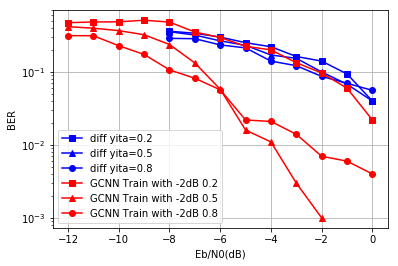

In [60]:
#------------------load BER---------------
import matplotlib.pyplot as plt
import numpy as np 
EbN0 = [-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0]
EbN02 = [-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2]
EbN0df = [-8,-7,-6,-5,-4,-3,-2,-1,0]
BER08 = np.loadtxt('BER_MSK_GCNN0905_tr-2dB_te_12_0_comb08.txt')
BER05 = np.loadtxt('BER_MSK_GCNN0905_tr-2dB_te_12_0_comb05.txt')
BER02 = np.loadtxt('BER_MSK_GCNN0905_tr-2dB_te_12_0_comb02.txt')
BERd_02 = np.loadtxt('BER_02.txt')
BERd_05 = np.loadtxt('BER_05.txt')
BERd_08 = np.loadtxt('BER_08.txt')

#BERv = np.loadtxt('BER_a15_ebn0_5_3.txt')
ebn0c = [-3,-2,-1,0,1,2,3]
#BERc = [0.18,0.12,0.08,0.045,0.025,0.012,0.0045]
ebn02 = [-5,-4,-3,-2,-1,0,1,2,3]
#plt.semilogy(ebn0c,BERc,'bs-',label = 'paper')
#plt.semilogy(EbN0,BERv,'b^-',label = 'viterbi')

BERdf = [3.7200000e-01,3.6500000e-01,2.8700000e-01,3.1800000e-01,2.4700000e-01,1.9300000e-01,1.5200000e-01,9.8000000e-02,9.5000000e-02]
ebn0df = [-8,-7,-6,-5,-4,-3,-2,-1,0]
BERv = [4.0492000e-01,3.8396000e-01,3.5986000e-01,3.2798000e-01,3.0494000e-01,2.7338000e-01,2.3950000e-01,2.0614000e-01,1.7750000e-01]
#plt.semilogy(ebn02,BERv,'b^-',label = 'viterbi')
plt.semilogy(EbN0df,BERd_02,'bs-',label = 'diff yita=0.2')
plt.semilogy(EbN0df,BERd_05,'b^-',label = 'diff yita=0.5')
plt.semilogy(EbN0df,BERd_08,'bo-',label = 'diff yita=0.8')
plt.semilogy(EbN0,BER02,'rs-',label = 'GCNN Train with -2dB 0.2')
plt.semilogy(EbN0,BER05,'r^-',label = 'GCNN Train with -2dB 0.5')
plt.semilogy(EbN0,BER08,'ro-',label = 'GCNN Train with -2dB 0.8')


plt.xlabel('Eb/N0(dB)')
plt.ylabel('BER')
plt.legend(loc=0)
#plt.axis([-8.2,0.2,0.00095,0.59])
plt.grid(True)
plt.show()

# yita = 0.2 train-2dB test -12-0dB

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


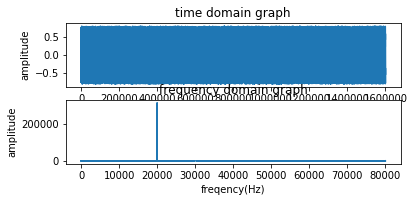

the noise has been prepared
the shape of impulsive noise (1600000,)
cmb [ 0.02485526 -0.53763368 -0.55839812 ...  0.05642595  0.58398511
  0.43951656]
im_noise [-0.28776752 -0.17865107  0.09041356 ... -0.21540347 -0.34535353
  0.45624869]
signals has been prepared
shape of X_train (1000, 1600) shape of y_train (1000, 2)
[[0. 1.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [1. 0.]]
Train on 800 samples, validate on 200 samples
Epoch 1/200
800/800 [==============================] - 0s 581us/step - loss: 0.0409 - acc: 0.9963 - val_loss: 0.0585 - val_acc: 0.9850
Epoch 2/200
800/800 [==============================] - 0s 591us/step - loss: 0.0341 - acc: 0.9950 - val_loss: 0.0515 - val_acc: 0.9850
Epoch 3/200
800/800 [==============================] - 0s 600us/step - loss: 0.0334 - acc: 0.9988 - val_loss: 0.0460 - val_acc: 0.9900
Epoch 4/200
800/800 [==============================] - 0s 604us/step - loss: 0.0301 - acc: 0.9950 - val_loss: 0.0475 - val_acc: 0.9900
Epoch 5/200
800/800 [===========

Epoch 118/200
800/800 [==============================] - 1s 625us/step - loss: 0.0038 - acc: 1.0000 - val_loss: 0.0236 - val_acc: 0.9900
Epoch 119/200
800/800 [==============================] - 1s 630us/step - loss: 0.0037 - acc: 1.0000 - val_loss: 0.0233 - val_acc: 0.9850
Epoch 120/200
800/800 [==============================] - 0s 598us/step - loss: 0.0040 - acc: 1.0000 - val_loss: 0.0232 - val_acc: 0.9900
Epoch 121/200
800/800 [==============================] - 0s 623us/step - loss: 0.0042 - acc: 1.0000 - val_loss: 0.0238 - val_acc: 0.9900
Epoch 122/200
800/800 [==============================] - 0s 623us/step - loss: 0.0039 - acc: 1.0000 - val_loss: 0.0246 - val_acc: 0.9900
Epoch 123/200
800/800 [==============================] - 0s 606us/step - loss: 0.0040 - acc: 1.0000 - val_loss: 0.0237 - val_acc: 0.9900
Epoch 124/200
800/800 [==============================] - 0s 595us/step - loss: 0.0039 - acc: 1.0000 - val_loss: 0.0229 - val_acc: 0.9900
Epoch 125/200
800/800 [==================

Epoch 178/200
800/800 [==============================] - 1s 638us/step - loss: 0.0027 - acc: 1.0000 - val_loss: 0.0253 - val_acc: 0.9900
Epoch 179/200
800/800 [==============================] - 1s 647us/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.0240 - val_acc: 0.9900
Epoch 180/200
800/800 [==============================] - 0s 612us/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.0232 - val_acc: 0.9900
Epoch 181/200
800/800 [==============================] - 1s 627us/step - loss: 0.0031 - acc: 1.0000 - val_loss: 0.0232 - val_acc: 0.9900
Epoch 182/200
800/800 [==============================] - 1s 641us/step - loss: 0.0033 - acc: 1.0000 - val_loss: 0.0240 - val_acc: 0.9900
Epoch 183/200
800/800 [==============================] - 0s 604us/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.0249 - val_acc: 0.9900
Epoch 184/200
800/800 [==============================] - 0s 599us/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.0252 - val_acc: 0.9900
Epoch 185/200
800/800 [==================

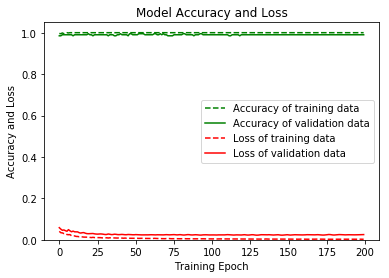

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:85: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


data_0 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0.
 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0.
 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0.
 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0.
 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1.
 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0.
 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1.
 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1.
 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1.
 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1

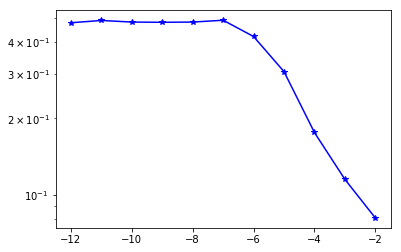

save txt have done


In [23]:
from pylab import *
#------------prepare combine noise-------------------
yita = 0.2  #yita = imnoise/combine noise
EbN0 = -2 # -6 #-4 #0 #6   #15
fs = fc*sample_num
def combnoise2(ebn0,length,fc,fs):
	N = length
	snr = 10**((ebn0)/10)
	Ptotal = 1/snr
	#length = 1000
	#P_im = Ptotal*yita
	P_comb = Ptotal*(1-yita)
	ts = np.arange(1/fs, (N+1) / fs, 1 / fs)
	#comb_noise = (P_comb**0.5)*np.random.randn(length)*np.cos(np.dot(2*pi*fc,ts))
	cosn = np.cos(np.dot(2*pi*fc,ts))
	sinn = np.sin(np.dot(2*pi*fc,ts))
	cmb_noise =  (P_comb**0.5)*np.random.random(length)*np.cos(np.dot(2*pi*fc,ts))- (P_comb**0.5)*np.random.random(length)*np.sin(np.dot(2*pi*fc,ts))
	return cmb_noise

cmb_noise = combnoise2(EbN0,len(signal_mod),fc,fs)
fft = np.fft.fft(cmb_noise)  #调用fft变换算法计算频域波形
fftx = np.linspace(0,fs/2,len(signal_mod)/2)  #频域波形x轴坐标311
subplot(312)
plot(cmb_noise)
xlabel('time(s)')
ylabel('amplitude')
title('time domain graph')

subplot(313)
plot(fftx,abs(fft[0:800000]))
xlabel('freqency(Hz)')
ylabel('amplitude')
title('frequency domain graph')

show()
im_noise=cmbn.imnoise(EbN0,yita,signal_mod.shape,alpha=1.5)  #alpha=1.2
signal_mod0 = signal_mod+im_noise+cmb_noise
#X_train = signal_mod0.reshape(data_len,sample_num,200)
print('the noise has been prepared')
print('the shape of impulsive noise',im_noise.shape)
#------prpare the data-+---------------
X_train=np.zeros((data_len,1600))
X_test=np.zeros((data_len,1600))
X_train = signal_mod0.reshape(data_len,1600) 

data_0=(data+1)/2

#X_train_pre=signal_mod
y_train = np_utils.to_categorical(data_0, num_classes=2)
print('cmb',cmb_noise)
print('im_noise',im_noise)
y_test=y_train
#X_train = X_train_pre.reshape(data_len,sample_num*multi)
X_test=X_train

print ('signals has been prepared')
print('shape of X_train',X_train.shape,'shape of y_train',y_train.shape)
print(y_train)

#*******************------------TRAIN-----------*******************
#-------------load the model-------------
from keras.models import load_model 
#model_m = load_model ('GCNN_tr-2dBv7_alpha15.h5')
##-----------the training parameters---------------
# Hyper-parameters
BATCH_SIZE = 500
EPOCHS = 200
#for i in range(2):
#    X_train[0:data_len,0:sample_num,i]= X_train[0:data_len,0:sample_num,i] +im_noise[0,0:data_len,0:sample_num]
    #X_test[0:data_len,0:sample_num,i]= X_test[0:data_len,0:sample_num,i] +im_noise[7,0:data_len,0:sample_num]
#X_test=X_test+im_noise
# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                    #  callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)
                     

# %%
#score = model_m.evaluate(X_test, y_test, verbose=1)
#print("\nAccuracy on test data: %0.2f" % score[1])
#print("\nLoss on test data: %0.2f" % score[0])
print("\n--- Learning curve of model training ---\n")
# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['acc'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_acc'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
#np.savetxt('loss_MSK_GCNN_tr-2dB_alpha12.txt',history.history['loss'],fmt='%0.8f')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()
model_m.save('GCNN_tr-2dB_comb08.h5')

#**********************------TEST-----------************************
#------test data generating---------------
data,data_p=symbol_out(data_len)
I_out,Q_out=IQ_msk(data,data_len,sample_num,Rb)
signal_mod=carriermod(fc,Rb,I_out,Q_out)
#--generate noise--------------


#X_train = signal_mod0.reshape(data_len,sample_num,200)

#signal_mod0 = signal_mod + im_noise

data_0=(data+1)/2
print('data_0',data_0)
Y_test = np_utils.to_categorical(data_0, num_classes=2)
print('Y_test',Y_test)
#*************alpha=1.5*******************************************
model2 = model_m
#-----test and plot----------
#---plot ber curve-------------
yita=0.2
EbN0 =[-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0] # ##[-5,-4,-3,-2,-1,0,1,2,3] #[-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2] # #[-8,-7,-6,-5,-4,-3,-2,-1,0]  #[1,2,3,4,5] # 
BER = [0]*len(EbN0)
loop_num = [1]*len(EbN0)    #[1,1,10,10,10,10,100,100,1000]
for i in range(len(EbN0)):
  #EbN0[i] = GSNR[i]/2
  cmb_noise = combnoise2(EbN0[i],len(signal_mod),fc,fs)
  #print(cmb_noise)


  im_noise=cmbn.imnoise(EbN0[i],yita,signal_mod.shape,alpha=1.5)
  signal_mod0 = signal_mod+im_noise+cmb_noise
  X_test = signal_mod0.reshape(data_len,1600) 
  BER_loop = [0]*loop_num[i]
  wrong = [0]*loop_num[i]
  wrong_sum = 0
  for loop in range(loop_num[i]):
    
    loss,accuracy = model2.evaluate(X_test, Y_test)
    BER_loop[loop] = 1- accuracy
    wrong[loop] = BER_loop[loop]*data_len
  wrong_sum = sum(wrong)
  BER[i] = wrong_sum/(data_len*loop_num[i])
  print('BER',BER[i])
plt.semilogy(EbN0,BER,'b*-')
plt.savefig('BER_MSK_GCNN_tr2dBv8_te_5_2dB_alpha12.jpg')
plt.show()
np.savetxt('BER_MSK_GCNN0905_tr-2dB_te_12_0_comb08.txt',BER,fmt='%0.8f')
print('save txt have done')
     

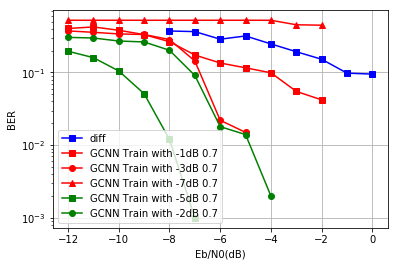

In [5]:
#-------------------plot the combine BER---------------
import matplotlib.pyplot as plt
import numpy as np 
EbN0 = [-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2]
BERt_1 = np.loadtxt('BER_MSK_GCNN_tr-1dBv20_te_12_2_comb.txt')
BERt_3 = np.loadtxt('BER_MSK_GCNN_tr-3dBv20_te_12_2_comb.txt')
BERt_7 = np.loadtxt('BER_MSK_GCNN_tr-7dBv20_te_12_2_comb.txt')
BERt_5 = np.loadtxt('BER_MSK_GCNN_tr-5dBv20_te_12_2_comb.txt')
BERt_2 = np.loadtxt('BER_MSK_GCNN_tr-2dBv20_te_12_2_comb.txt')


#BERv = np.loadtxt('BER_a15_ebn0_5_3.txt')
ebn0c = [-3,-2,-1,0,1,2,3]
#BERc = [0.18,0.12,0.08,0.045,0.025,0.012,0.0045]
ebn02 = [-5,-4,-3,-2,-1,0,1,2,3]
#plt.semilogy(ebn0c,BERc,'bs-',label = 'paper')
#plt.semilogy(EbN0,BERv,'b^-',label = 'viterbi')

BERdf = [3.7200000e-01,3.6500000e-01,2.8700000e-01,3.1800000e-01,2.4700000e-01,1.9300000e-01,1.5200000e-01,9.8000000e-02,9.5000000e-02]
ebn0df = [-8,-7,-6,-5,-4,-3,-2,-1,0]
BERv = [4.0492000e-01,3.8396000e-01,3.5986000e-01,3.2798000e-01,3.0494000e-01,2.7338000e-01,2.3950000e-01,2.0614000e-01,1.7750000e-01]
#plt.semilogy(ebn02,BERv,'b^-',label = 'viterbi')
plt.semilogy(ebn0df,BERdf,'bs-',label = 'diff')
plt.semilogy(EbN0,BERt_1,'rs-',label = 'GCNN Train with -1dB 0.7')
plt.semilogy(EbN0,BERt_3,'ro-',label = 'GCNN Train with -3dB 0.7')
plt.semilogy(EbN0,BERt_7,'r^-',label = 'GCNN Train with -7dB 0.7')
plt.semilogy(EbN0,BERt_5,'gs-',label = 'GCNN Train with -5dB 0.7')
plt.semilogy(EbN0,BERt_2,'go-',label = 'GCNN Train with -2dB 0.7')


plt.xlabel('Eb/N0(dB)')
plt.ylabel('BER')
plt.legend(loc=0)
#plt.axis([-6,2.1,0.1,0.5])
plt.grid(True)
plt.show()

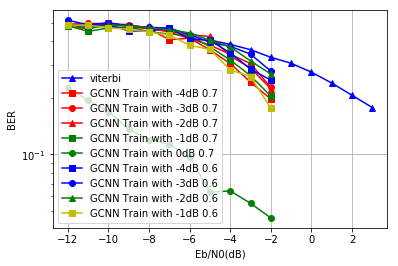

In [14]:
#-------------------plot the combine BER---------------
import matplotlib.pyplot as plt
import numpy as np 
#EbN0 = [-5,-4,-3,-2,-1,0,1,2,3]
BERt7_4 = np.loadtxt('BER_MSK_GCNN_tr-4dB_te_12_4_comb07.txt')
BERt7_3 = np.loadtxt('BER_MSK_GCNN_tr-3dB_te_12_4_comb07.txt')
BERt7_2 = np.loadtxt('BER_MSK_GCNN_tr-2dB_te_12_4_comb07.txt')
BERt7_1 = np.loadtxt('BER_MSK_GCNN_tr-10dBv8_te_12_4_comb07.txt')
BERt70 = np.loadtxt('BER_MSK_GCNN_tr0dB_te_12_4_comb07.txt')
BERt6_4 = np.loadtxt('BER_MSK_GCNN_tr-4dB_te_12_4_comb06.txt')
BERt6_3 = np.loadtxt('BER_MSK_GCNN_tr-3dB_te_12_4_comb06.txt')
BERt6_2 = np.loadtxt('BER_MSK_GCNN_tr-2dB_te_12_4_comb06.txt')
BERt6_1 = np.loadtxt('BER_MSK_GCNN_tr-10dBv8_te_12_4_comb06.txt')
BERt60 = np.loadtxt('BER_MSK_GCNN_tr0dB_te_12_4_comb06.txt')


#BERv = np.loadtxt('BER_a15_ebn0_5_3.txt')
ebn0c = [-3,-2,-1,0,1,2,3]
#BERc = [0.18,0.12,0.08,0.045,0.025,0.012,0.0045]
ebn02 = [-5,-4,-3,-2,-1,0,1,2,3]
#plt.semilogy(ebn0c,BERc,'bs-',label = 'paper')
#plt.semilogy(EbN0,BERv,'b^-',label = 'viterbi')
BERv = [4.0492000e-01,3.8396000e-01,3.5986000e-01,3.2798000e-01,3.0494000e-01,2.7338000e-01,2.3950000e-01,2.0614000e-01,1.7750000e-01]
plt.semilogy(ebn02,BERv,'b^-',label = 'viterbi')
plt.semilogy(EbN0,BERt7_4,'rs-',label = 'GCNN Train with -4dB 0.7')
plt.semilogy(EbN0,BERt7_3,'ro-',label = 'GCNN Train with -3dB 0.7')
plt.semilogy(EbN0,BERt7_2,'r^-',label = 'GCNN Train with -2dB 0.7')
plt.semilogy(EbN0,BERt7_1,'gs-',label = 'GCNN Train with -1dB 0.7')
plt.semilogy(EbN0,BERt70,'go-',label = 'GCNN Train with 0dB 0.7')
plt.semilogy(EbN0,BERt6_4,'bs-',label = 'GCNN Train with -4dB 0.6')
plt.semilogy(EbN0,BERt6_3,'bo-',label = 'GCNN Train with -3dB 0.6')
plt.semilogy(EbN0,BERt6_2,'g^-',label = 'GCNN Train with -2dB 0.6')
plt.semilogy(EbN0,BERt6_1,'ys-',label = 'GCNN Train with -1dB 0.6')


plt.xlabel('Eb/N0(dB)')
plt.ylabel('BER')
plt.legend(loc=0)
#plt.axis([-6,2.1,0.1,0.5])
plt.grid(True)
plt.show()